In [ ]:
## PDBbind dataset
import pandas as pd
import numpy as np

## lead and set up dataset
pdbbind = pd.read_csv('data/pdbbind.csv') ## load dataset
cols = ['pdb_id', 'lig_id', 'mix_affinity_data', 'Y'] ## rename columns
pdbbind = pdbbind.loc[:, ['PDB code', 'Ligand Name', 'Affinity Data', 'pKd pKi pIC50']] ## extract particular columns
pdbbind.columns = cols ## re-label columns
pdbbind = pdbbind.dropna() ##drop NA values
pdbbind = pdbbind[~pdbbind['lig_id'].str.contains('-mer', case=False)] # remove data without lig_id

## get dataset by kd type of data 
IC50_pdbbind = pdbbind[pdbbind['mix_affinity_data'].str.contains('IC50=', case=False)]
IC50_pdbbind[['metric', 'value', 'units']] = IC50_pdbbind['mix_affinity_data'].str.extract(r'(\w+)=([\d.]+)(\w+)') ## split column
IC50_pdbbind.drop('mix_affinity_data', axis=1, inplace=True) ## remove column
IC50_pdbbind.dropna() ## drop NA columns 
IC50_pdbbind['lig_id'] = IC50_pdbbind['lig_id'].str.replace('[\W_]+', '') ## remove non-alphanumeric characters
IC50_pdbbind = IC50_pdbbind.drop_duplicates(subset=['lig_id']) ## remove duplicates on ligands

## function to convert units to uM
def convert_units(row):
    value = row['value']
    unit = row['units']

    # Convert the value to uM
    if unit == 'nM':
        value *= 1e-3
    elif unit == 'mM':
        value *= 1e3
    elif unit == 'pM':
        value *= 1e-6

    # Update the value and unit
    row['value'] = value
    row['units'] = 'uM'

    return row

## convert units to uM
IC50_pdbbind['value'] = pd.to_numeric(IC50_pdbbind['value'], errors='coerce') ##convert to numeric
IC50_pdbbind = IC50_pdbbind.apply(convert_units, axis=1)

## convert to logaritmic version of it [pIC50]
IC50_pdbbind['Y'] = IC50_pdbbind['value'].apply(lambda x: -1.0 * np.log10(x)) ## convert to pIC50 [Y]
IC50_pdbbind = IC50_pdbbind.dropna() ## drop NA columns
IC50_pdbbind.reset_index(drop=True, inplace=True) ## reset index

## arbitrary threshold based on the mean
mean_value = IC50_pdbbind['Y'].mean()
IC50_pdbbind['Activity'] = IC50_pdbbind['Y'].apply(lambda x: 1 if x > mean_value else 0)
# IC50_pdbbind.to_csv('data/IC50_pdbbind_.csv', index=False) ## save dataset 

## dataset has been also manually curated to fix some issues like:
## getting smiles of few of them since lig_id was not in right format
# for example '77' instead of '077'
## manually corrected dataset is saved as IC50_pdbbind.csv ##

In [1]:
## check for balance
import pandas as pd 
df = pd.read_csv('data/IC50_pdbbind.csv')
active_count = (df['Activity'] == 1).sum()
inactive_count = (df['Activity'] == 0).sum()

print(f'Number of active (1): {active_count}')
print(f'Number of inactive (0): {inactive_count}')

Number of active (1): 3311
Number of inactive (0): 2775


count    6086.000000
mean        0.696339
std         1.608013
min        -5.550228
25%        -0.302655
50%         0.886057
75%         1.886057
max         5.522879
Name: Y, dtype: float64


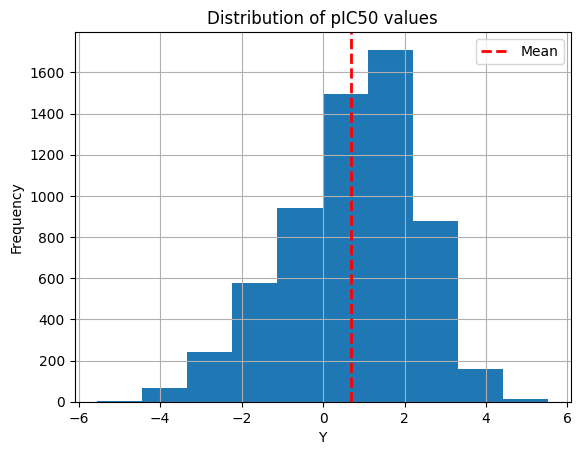

In [2]:
## check for distribution
import matplotlib.pyplot as plt

print(df['Y'].describe())

# Create a histogram to visualize the distribution
df['Y'].hist(bins=10)
plt.xlabel('Y')
plt.ylabel('Frequency')
plt.title('Distribution of pIC50 values')

# Calculate the mean of your data
mean_value = df['Y'].mean()

# Add a vertical line at the mean
plt.axvline(mean_value, color='r', linestyle='dashed', linewidth=2, label='Mean')

# Show the plot
plt.legend()
plt.show()

In [ ]:
import os
import pandas as pd
import yaml
